In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import polars as pl
from icecream import ic
from polars import col

from src.data.database_manager import DatabaseManager
from src.data.quality_checks import check_sample_rate
from src.features.resampling import interpolate_and_fill_nulls
from src.features.scaling import scale_min_max, scale_robust_standard
from src.features.transforming import map_trials
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    ppg = db.get_table("Feature_PPG", exclude_trials_with_measurement_problems=False)
    stimulus = db.get_table(
        "Feature_Stimulus", exclude_trials_with_measurement_problems=False
    )
ppg

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,ppg_raw,ppg_heartrate_shimmer,ppg_ibi_shimmer,ppg_clean,ppg_rate,ppg_quality,ppg_peaks,heartrate
u16,u8,u8,u32,f64,i64,f64,i64,f64,f64,f64,f64,i64,f64
1,2,1,64697,505421.2712,84929,1358.07664,64,-2.996566,11.429259,68.002623,0.908636,0,68.002623
1,2,1,64710,505527.9864,84942,1439.150876,61,85.531675,79.662835,67.999126,0.908636,0,67.999126
1,2,1,64722,505631.7088,84954,1430.680033,61,-21.97456,60.198949,68.006443,0.908636,0,68.006443
1,2,1,64736,505722.4665,84968,1428.891593,61,2.00116,47.766474,67.995175,0.908636,0,67.995175
1,2,1,64749,505827.1857,84981,1414.656225,61,6.040751,24.486436,68.013518,0.908636,0,68.013518
1,2,1,64762,505929.5995,84994,1383.896753,61,-14.379081,-13.787253,67.999794,0.908636,0,67.999794
…,…,…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,345041,2.6956e6,473254,1353.579373,61,-14.52735,43.991467,50.277138,0.953552,0,50.277138
513,12,50,345053,2.6957e6,473266,1259.58262,61,15.444632,-36.62174,50.237464,0.953669,0,50.237464


In [5]:
ppg.hvplot(
    x="timestamp",
    y=[
        "heartrate",
    ],
    groupby="trial_id",
    ylim=(0, 200),
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'87aa62eb-054e-42f2-8c9f-700132a1bfb0': {'version…

## Heartrates per participant

<Axes: >

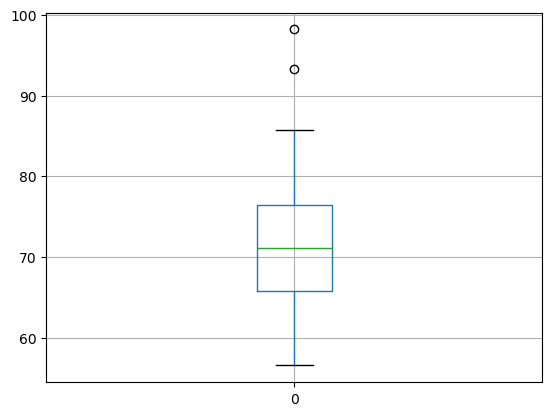

In [6]:
heartrates = []
for group in ppg.group_by("participant_id", maintain_order=True):
    heartrates.append(group[1].get_column("heartrate").mean())
pd.DataFrame(heartrates).boxplot()

## Neurokit analysis based on raw PPG data

In [8]:
with db:
    raw_ppg = db.get_table("Raw_PPG", exclude_trials_with_measurement_problems=False)

In [9]:
one_participant = raw_ppg.filter(col("participant_id") == 1)
one_trial = raw_ppg.filter(col("trial_id") == 1)

signals, info = nk.ppg_process(
    one_trial.get_column("ppg_raw").to_numpy(), sampling_rate=100
)


In [10]:
# Visualize the processing
nk.ppg_plot(signals, info)

In [7]:
@map_trials
def nk_process_ppg(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    """
    Process the raw PPG signal using NeuroKit2 and the "elgendi" method.

    Creates the following columns:
    - ppg_clean
    - ppg_rate
    - ppg_quality
    - ppg_peaks

    Note that neurokit approach is non-causal, i.e. it uses future data to calculate
    the signal.
    """

    return (
        df.with_columns(
            col("ppg_raw")
            .map_batches(
                lambda x: pl.from_pandas(
                    nk.ppg_process(  # returns a tuple, we only need the pd.DataFrame
                        ppg_signal=x.to_numpy(),
                        sampling_rate=sampling_rate,
                        method="elgendi",
                    )[0].drop("PPG_Raw", axis=1)
                ).to_struct()
            )
            .alias("ppg_components")
        )
        .unnest("ppg_components")
        .select(pl.all().name.to_lowercase())
    )
